### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------

Stephen Law, Igor Tkalec, Thomas Keel, and Gong Jie

For this second task, we would like you to analyse a dataset that contains review data of different venues in the city of Calgary,
Canada. With the help of several machine learning techniques that we have learnt in the course, you will be tasked to distill
insights from this social media dataset. Two of its notable features are the geocoding of every reviewed venues and the
availability of a considerable amount of text data in it, which lend to its ability to be processed using spatial and text analysis
techniques respectively.

As a prelude to the analysis prompts below, have a brief think about some of these questions: What can we discover about the
venue review data? Are there any spatial patterns that can be extracted from the data? Can we build a machine learning model
that predicts review rating for unseen data points using the text of the reviews?

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

### 3.2.1 Loading and cleaning the textual dataset


#### 3.2.1.1 Loading the data


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import seaborn as sns
import time
import geopandas as gpd
import folium
from geopy.distance import geodesic
from math import radians


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.inspection import permutation_importance


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score

from scipy.sparse import hstack


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We load the data frame.

In [2]:
data = pd.read_csv('Calgary.csv')

#### 3.2.1.2 Positive/Negative Variable


We create a column that stores the polarity score variable with two categories (1 = positive (4+ stars); 0 = negative (3 or less stars). Even though this step is not mentioned until 3.2.2, it is interesting to see the distribution of this variable alongside the other variables in the next step.

In [3]:
data['positive'] = data['stars_y'].apply(lambda x: 1 if x >= 4 else 0)
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0


#### 3.2.1.3 Describing numeric variables and checking distribution of these attributes


We describe the numeric variables in the data: Latitude, longitude, review count, stars, useful, funny, cool, and the recently created 'positive'.

In [4]:
data.describe()

,latitude,longitude,review_count,stars_y,useful,funny,cool,positive
count,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000
mean,51.042724,-114.070648,61.995254,3.618639,1.293203,0.391083,0.382578,0.640262
std,0.051552,0.053040,77.290191,1.424214,2.830347,1.306604,1.171075,0.479926
min,50.865169,-114.379523,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,51.033200,-114.086896,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,51.044727,-114.070254,36.000000,4.000000,0.000000,0.000000,0.000000,1.000000
75%,51.066428,-114.053056,78.000000,5.000000,2.000000,0.000000,0.000000,1.000000
max,51.207540,-113.714140,512.000000,5.000000,104.000000,59.000000,69.000000,1.000000


We plot these to check their distributions

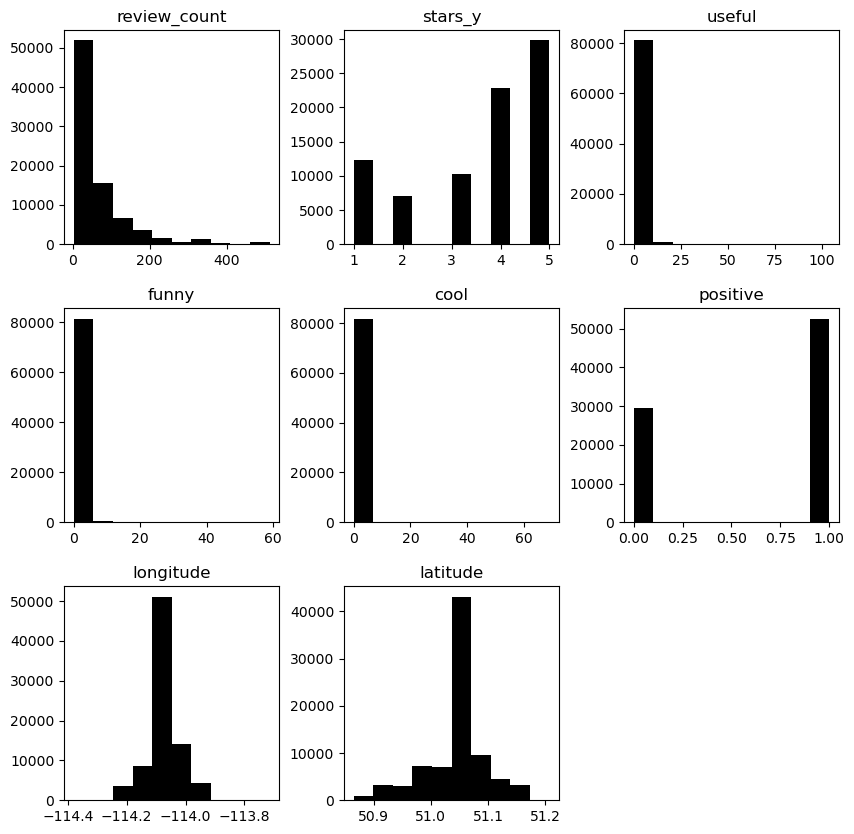

In [5]:
numeric_cols = ['review_count','stars_y', 'useful', 'funny', 'cool', 'positive', 'longitude', 'latitude']
numeric_data = data[numeric_cols]
numeric_data.hist(figsize=(10,10),color='black',grid=False)
#plt.axis(False)
plt.show()

We build a correlation heatmap to dicover the variables further. 

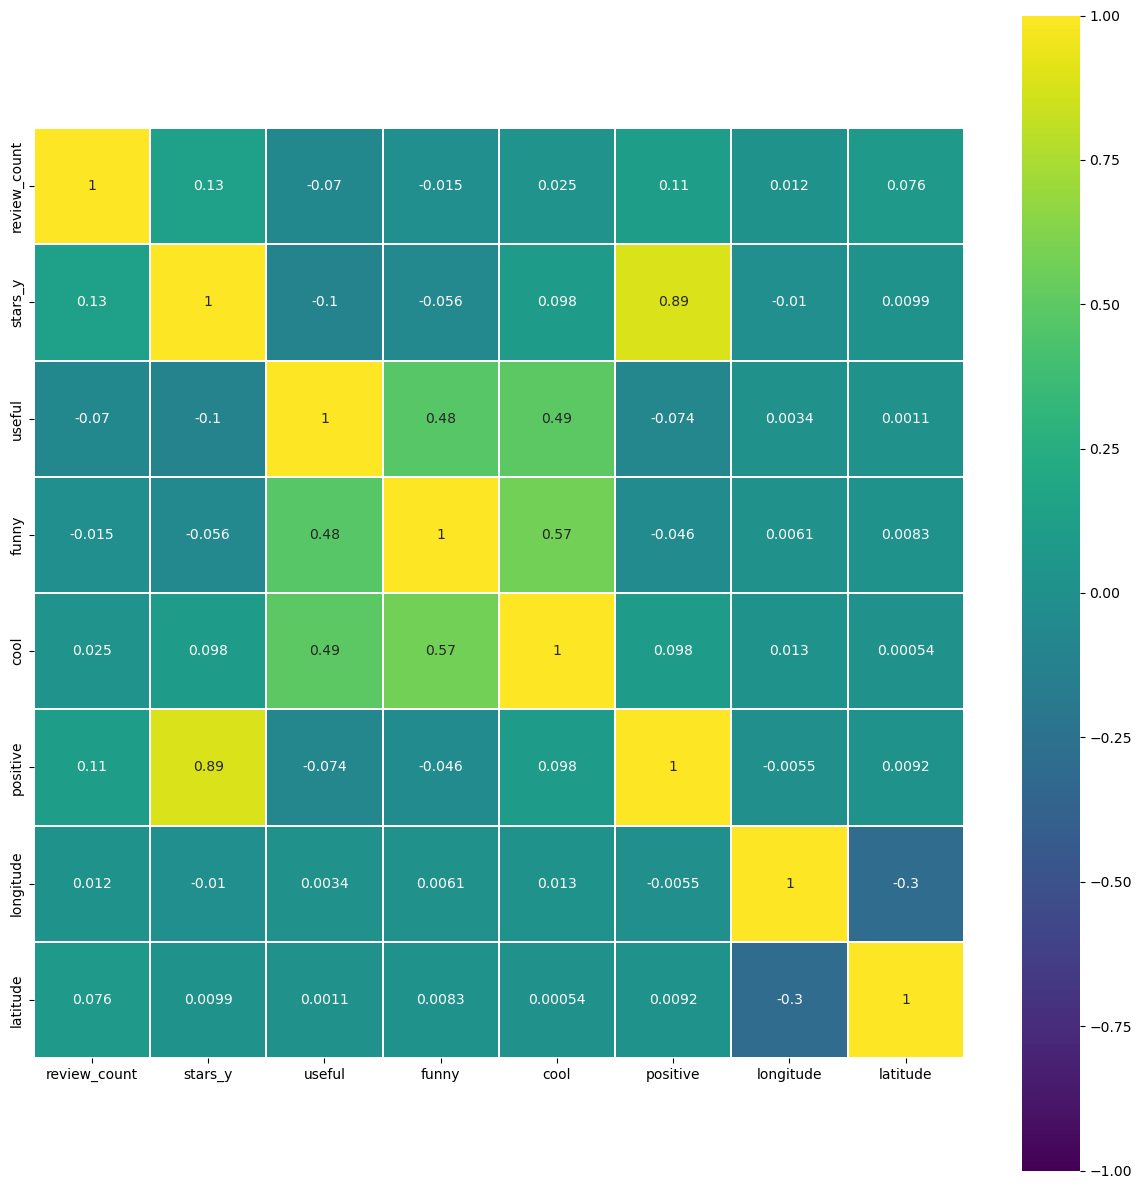

In [6]:
corr = data[numeric_data.columns].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0,cmap=plt.get_cmap('viridis'),
            square=True, linewidths=.05, annot=True, vmin=-1, vmax=1,ax=ax) 
plt.show()

#### 3.2.1.4 Discovering categorical variables


In [7]:
categorical_data = data.select_dtypes(include=[object])
categorical_data.columns

Index(['business_id', 'name', 'categories', 'hours', 'review_id', 'user_id',
       'text', 'date'],
      dtype='object')

We observe how business categories are inputted in the data for our future analysis

#### 3.2.1.5 Pre-process text reviews

We define a function to pre-process our text column. 
This function 
* removes punctuation and numbers, 
* turns words into lowercase, 
* tokenizes them, 
* removes stop words, 
* lemmatizes the tokens
* joins the tokens back into a string.
In the end, we join this new pre-processed text as a new column to our data.

In [8]:
lemmatizer = WordNetLemmatizer()

import re

# Define a function for text preprocessing
def preprocess_text(text):
     
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    #even though the punctuation is only removed for the words that are not in stop words
    #some comments just have stop words without punctuation (typos)
    #Therefore we remove them manually
    newStopWords = ['youre','youve',"youve", "youll", "youd", 
                    "shes", "thatll", "dont", "shouldve", "arent", 
                    "couldnt", "didnt", "doesnt", "hadnt", "hasnt", 
                    "havent", "isnt", "mightnt", "mustnt", "neednt",
                    "shant","shouldnt", "wasnt", "werent", "wont", 
                    "wouldnt", "i'm", "im"] 
    stop_words.update(newStopWords)
    #Lowercase
    text = text.lower()
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Tokenize the text
    tokens = text.split()
    
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens if token not in stop_words]
    

    
    tokens = [token.translate(str.maketrans('', '', string.digits)) for token in tokens]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
   
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text
data['preprocessed_text'] = data['text'].apply(preprocess_text)

We remove the rows that have empty 'preprocessed_text' cells after our treatment for it to not affect our analysis. 

In [9]:
(data['preprocessed_text'] == '').sum()

6

In [10]:
data = data[data['preprocessed_text'] != '']

### 3.2.2 Build a supervised learning for text analysis


#### 3.2.2.1 Models with only text 

We are definig the vectorizer that is going to be used in the model. Since we already have a column of cleaned data, we do not include a text cleaning process into this vectoriser.

This vectorizer removes the words that occur in more that 95% of the observations and less than 1% of the observations. This helps us remove words are too frequent too infrequent to be relevant to help our model classify observations.

We visualise the output of this vectorizer. 

In [11]:
text_column = data['preprocessed_text'].tolist()
#turns text data into feature vectors
vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=0.01)

#check how it looks
text_column_transformed = vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_transformed.toarray(),columns=[vectorizer.get_feature_names_out()])

,able,about,absolutely,accommodating,across,actually,add,added,addition,afternoon,...,wrap,write,wrong,year,yelp,yes,yet,you,young,yummy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82171,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


However, there can be an even better way to vectorize our text data. We define a term frequency - inverse document frequency vectorizer. This improves the accuracy of our models because it takes into the length of the document into account when considering term frequency.

In [12]:
#turns text data into feature vectors
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, 
                                    min_df=0.01)

#check how it looks
text_column_tfidf = tfidf_vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_tfidf.toarray(),columns=[tfidf_vectorizer.get_feature_names_out()])
    

,able,about,absolutely,accommodating,across,actually,add,added,addition,afternoon,...,wrap,write,wrong,year,yelp,yes,yet,you,young,yummy
0,0.132015,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.163071,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.102244,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82171,0.000000,0.0,0.0,0.0,0.0,0.134775,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.143407,0.0,0.0
82172,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
82173,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
82174,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


We test and train split our data. Our predictor is the preprocessed text and our target categories are positive and negative.

We apply a 10% test size. Then, we apply our vectorizer to the text train and text test sets. 

In [79]:
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


##### 3.2.2.1.a Defining Useful Functions

We define a function to print out necessary statistics (f1 score, accuracy score, mse, r2 and recall) and visualisations for us to evaluate the model performance. 

In [14]:
def printStats(y_test, y_pred):
    # y_test contains the true ratings and y_pred contains the predicted ratings
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
  
    print("MSE:", mse)
    print("R2-score:", r2)
   
        
    print ("F1 score:", f1_score(y_test, y_pred, average='macro'))
    print ("Accuracy:", accuracy_score(y_test, y_pred)) 
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    
    #creates a grid to plot on
    f, ax = plt.subplots(figsize=(7, 5))
    #plots confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()

We also define a function to show whether a model is overfitting or not by comparing training set accuracy and test set accuracy of the model.

In [15]:
def crossVal(model, x_train, y_train, x_test, y_test):
# Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, x_train, y_train, cv=5)

# Calculate the training and test accuracy of the model
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)

# Compare the cross-validation score to the training and test accuracy
    if cv_scores.mean() > train_accuracy and cv_scores.mean() > test_accuracy:
        print("The model is likely overfitting.")
    else:
        print("The model is not overfitting.")


We define a function that splits the data into 5 folds and give us the mean accuracy of the model.

In [16]:
def crossValScore(model, x_train_vectors, y_train,):
# split the data into 5 folds
    cv = 5

# perform k-fold cross-validation and compute the mean accuracy score
    scores = cross_val_score(clf_logistic, x_train_vectors, y_train, cv=cv)

# print the mean accuracy score and its standard deviation
    print("Mean accuracy: {:.2f}%, Standard deviation: {:.2f}%".format(scores.mean()*100, scores.std()*100))

Finally, we define a function to print the permutation importance of added non-categorical values for section 3.2.2.2.

In [17]:
def permImp(model, x_test_vectors, y_test, feature_cols):

# convert the sparse matrix to a dense numpy array
    x_test_dense = x_test_vectors.toarray()

# calculate the permutation importance of the new features
    result = permutation_importance(model, x_test_dense, y_test, n_repeats=10, random_state=0)
    for i in result.importances_mean.argsort()[::-1]:
        if i >= len(result.importances_mean.argsort()) - len(feature_cols):
            print(f"{feature_cols[i-(len(result.importances_mean.argsort())-len(feature_cols))]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

We fit our classifiers:
* Naive Bayes Classifier
* Logistic Regression Classifier
* Random Forest Classifier 

Disclaimer: Random Forest Classifier may take more time than the others. 

##### 3.2.2.1.b Naive Bayesian Model

MSE: 0.17936237527378923
R2-score: 0.21936700409606824
F1 score: 0.787287648193914
Accuracy: 0.8206376247262107
Recall: 0.7703382413973547


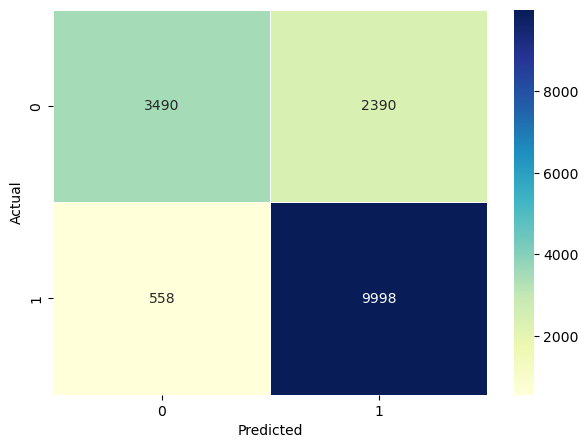

In [81]:
# Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(x_train_vectors, y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = clf.predict(x_test_vectors)
printStats(y_test, y_pred)

In [82]:
crossValScore(clf, x_train_vectors, y_train)

Mean accuracy: 86.94%, Standard deviation: 0.18%


##### 3.2.2.1.c Logistic Regression Classifier Model

MSE: 0.1318447310781212
R2-score: 0.426176491816886
F1 score: 0.854223947570605
Accuracy: 0.8681552689218788
Recall: 0.8489164366011657


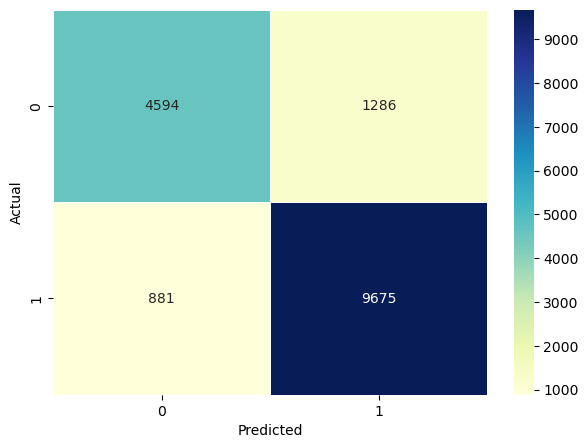

In [83]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

At some point, our logistic regression doesn't converge. We increase the maximum iteration to fix this. In the confusion matrix, we see that False Positives are disproportionally higher than false negatives. 


We also check the cross validation score of the model.

In [84]:
crossValScore(clf_logistic, x_train_vectors, y_train)

Mean accuracy: 86.94%, Standard deviation: 0.18%


We conduct a grid search to determine the best 'C' hyperparameter for our logistic model. C represents inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization [1].

In [85]:

# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors, y_train)
    

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

We define a function to do this grid search again with less clutter. 

In [86]:
def gridSearchLogReg(x_train_vectors, y_train):
    # create an instance of the Logistic Regression Classifier
    clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
    param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
    grid_search = GridSearchCV(clf_logistic, param_grid, cv=3, scoring='accuracy')

    # fit the grid search object on the training data
    grid_search.fit(x_train_vectors, y_train)
    
    print("Best parameters:", grid_search.best_params_, "Score:", grid_search.best_score_)
    return grid_search.best_estimator_

In [87]:
gridSearchLogReg(x_train_vectors, y_train)

Best parameters: {'C': 1} Score: 0.8683601910805153


LogisticRegression(C=1, max_iter=10000)

We refit the model with the best parameters as the result of the grid search.

MSE: 0.1318447310781212
R2-score: 0.426176491816886
F1 score: 0.854223947570605
Accuracy: 0.8681552689218788
Recall: 0.8489164366011657


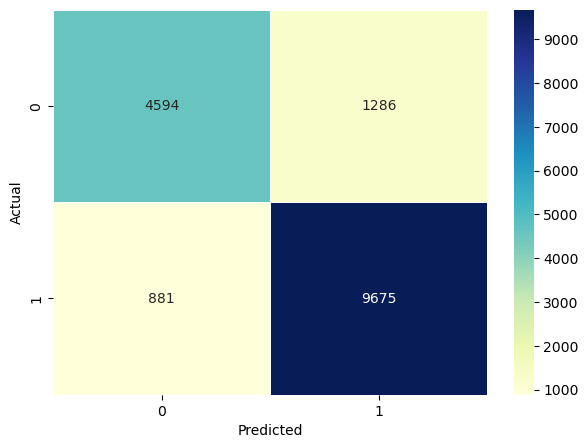

In [88]:

#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

We check the cross validation score again with the new parameters.

In [89]:
crossValScore(clf_logistic, x_train_vectors, y_train)

Mean accuracy: 86.94%, Standard deviation: 0.18%


We check whether the model is overfitting. 

In [90]:
crossVal(clf_logistic, x_train_vectors, y_train, x_test_vectors, y_test )

The model is not overfitting.


##### 3.2.2.1.d Random Forest Classifier Model

We then fit a Random Forest Classifier model. The reader should note that it takes significantly longer than the other models to run. 

Random forest complete, elapsed time: 272.23163390159607
MSE: 0.15076660988074958
R2-score: 0.3438234179613491
F1 score: 0.829798460629253
Accuracy: 0.8492333901192505
Recall: 0.8194197838286508


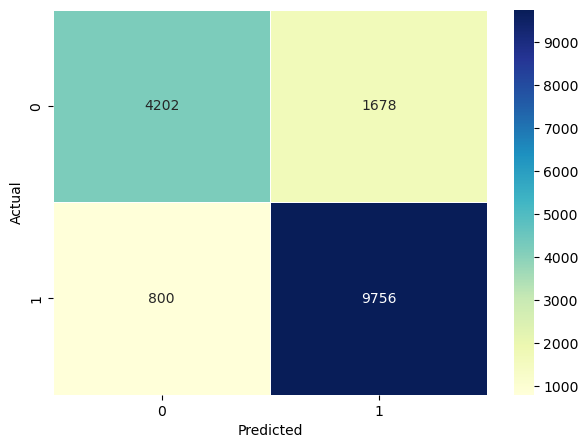

In [91]:
# Random Forest Classifier

start = time.time()
# create an instance of the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=1)

# fit the classifier on the training data
clf_forest.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_forest.predict(x_test_vectors)

duration = time.time() - start
print("Random forest complete, elapsed time:", duration)

printStats(y_test, y_pred)

We try to run our cross validation function to see whether it is overfitting or not. However, due to the nature of the model, it takes too much time (around 3-4 hours with a 1.1 GHz Quad-Core processor).

In [28]:
#crossVal(clf_forest, x_train_vectors, y_train, x_test_vectors, y_test )
#takes too long to compute, approx 15 mins

###### 3.2.2.1.d.i Grid Search CV


We run a grid search for our Random Forest Model regarding mac depth and n estimators hyperparameters. 

In [29]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 30, 60, 100],
    'n_estimators': [10, 50, 100, 200, 300]
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

In [30]:
grid_search.fit(x_train_vectors, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
model = grid_search.best_estimator_
best_param = grid_search.best_params_
y_pred=model.predict(x_test_vectors)
print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred),3)))

In [ ]:
best_param

In [ ]:
searchResults = pd.DataFrame(grid_search.cv_results_)
searchResults.head()
scores = searchResults.mean_test_score
depth = searchResults.param_max_depth
estimators = searchResults.param_n_estimators
estimators

We create a pivot table to assess the performance of the parameters.

In [ ]:
#create pivot table
grid_reset = searchResults.groupby(['param_max_depth', 'param_n_estimators'])["mean_test_score"].mean().reset_index()
grid_reset.columns = ['param_max_depth', 'param_n_estimators', 'mean_test_score']
grid_pivot = grid_reset.pivot('param_max_depth', 'param_n_estimators')
grid_pivot

We plot the parameters and their performance to see which one works better. 

In [ ]:
#plot 3D 
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

plt.pcolor(x, y, z)
plt.colorbar()
plt.xlabel("n_estimators")
plt.ylabel("max_depth")

We plug these hyperparameters into our Random Forest Model. 

In [ ]:
# Random Forest Classifier

# create an instance of the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=1, **grid_search.best_params_)

# fit the classifier on the training data
clf_forest.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_forest.predict(x_test_vectors)
printStats(y_test, y_pred)

#### 3.2.2.2 Models with text and non-text features

##### 3.2.2.2.a Sentiment Analysis (Lexicon Based) as a feature

As an experimental feature, we run a lexicon based sentiment analysis of our tokenized text cells and store the scores as a new column to use in our model. 

In [92]:
sid = SentimentIntensityAnalyzer()

data['sentiment_score'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


/var/folders/ph/c8qrnk695bg39ggsrrps3r2h0000gn/T/ipykernel_35492/3275819504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [93]:
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1,david came spring give estimate redoing centre...,0.8807
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1,chinook landscaping company would recommend ev...,0.9613
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1,chinook landscaping top book extremely pleased...,0.9945
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1,looking supplier game table pool cue accessory...,0.9738
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1,sml personal wet dream mine exterior deceiving...,0.9843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1,rarely post review wanted express impressed cu...,0.8807
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1,used martin pest control underconcrete frontst...,-0.5574
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0,company came home inspected place wrote report...,-0.9371
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0,would never recommend anyone purchased home mo...,-0.8903


We refresh the test and training sets to include the sentiment analsysis.

In [94]:
#refresh the sets so that they would include the sentiment analysis
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


We write a function to add non-text features to add to our model. We will take an iterative approach since features that are used together might influence the importance of the others. First, we will introduce all numeric variables as feature and we will check whether it will improve the model accuracy and other statistics (r2, mse etc.) and whether they have permutation importance that is statistically significant. Then we will remove the features that are not statistically significant or worsens the model and repeat the process until we reach a feature combination that improves model accuracy and have statistically significant and positive permutation importance.

In [95]:
# Takes a matrix of new features
def addFeatures(x_train_vectors, x_test_vectors, train_features, test_features):
    return (hstack((x_train_vectors, train_features)), 
            hstack((x_test_vectors, test_features)))


feature_cols = ["cool", "funny", "useful", "latitude", "longitude", "review_count", "sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

Logistic regression is the best performing classifier among the three, therefore we use that to compare model outputs before and after adding these new features. 

MSE: 0.12709905086395717
R2-score: 0.4468309605009113
F1 score: 0.8592477877620797
Accuracy: 0.8729009491360429
Recall: 0.8533643696205273


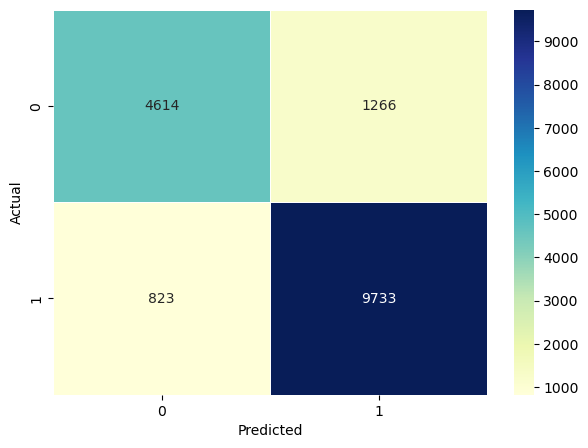

In [96]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_feature = clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

We inquire cross validation score and the best C hyperparameter value to know more about this model with the added features. 

In [97]:
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors, y_train)
print("Best parameters:", grid_search.best_params_, "Accuracy Score:", grid_search.best_score_)


Best parameters: {'C': 1} Accuracy Score: 0.8731061758442349


In [98]:
gridSearchLogReg(x_train_vectors, y_train)

Best parameters: {'C': 1} Score: 0.8731213772749942


LogisticRegression(C=1, max_iter=10000)

We plug in the best parameters into our model and fit it again.

MSE: 0.12709905086395717
R2-score: 0.4468309605009113
F1 score: 0.8592477877620797
Accuracy: 0.8729009491360429
Recall: 0.8533643696205273


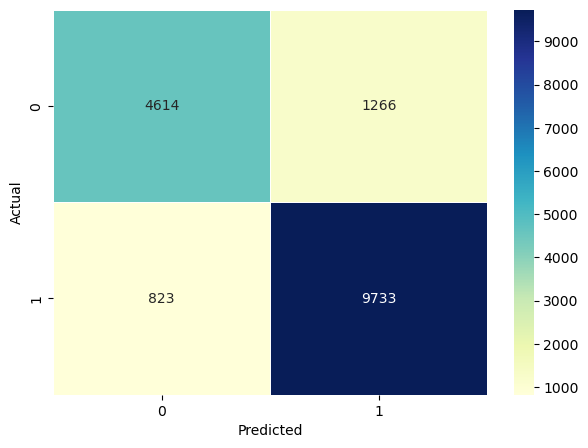

In [99]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [100]:
crossValScore(clf_logistic, x_train_vectors, y_train)

Mean accuracy: 87.31%, Standard deviation: 0.17%


We check the coefficients of these additional values to assess the feature importance. 

In [101]:
# Train the logistic regression model
clf = LogisticRegression(max_iter=10000, random_state=1, C=grid_search.best_params_['C']).fit(x_train_vectors, y_train)

# Extract the coefficient estimates for the additional features
additional_features_coef = clf.coef_[0][-len(feature_cols):]

# Create a dataframe to display the feature importance
importance_df = pd.DataFrame({'feature': feature_cols, 
                              'importance': additional_features_coef})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)


           feature  importance
6  sentiment_score    1.503068
3         latitude    0.577543
0             cool    0.362855
4        longitude    0.261727
5     review_count    0.001237
2           useful   -0.048183
1            funny   -0.104735


However, there is also a model agnostic way of assessing feature importance: permutation importance. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature [2].

In [102]:
permImp(clf_logistic, x_test_vectors, y_test, feature_cols)

sentiment_score: 0.028 +/- 0.001
cool: 0.007 +/- 0.001
useful: 0.001 +/- 0.000
funny: 0.001 +/- 0.000
longitude: -0.000 +/- 0.000
latitude: -0.000 +/- 0.000
review_count: -0.000 +/- 0.001


We eliminate useful since the value is zero and it can swing negative with the error term.

In [142]:
#refresh the sets
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


In [143]:
feature_cols = ["cool", "funny", "useful","sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

MSE: 0.12624726210756876
R2-score: 0.45053817282881325
F1 score: 0.8606896788754275
Accuracy: 0.8737527378924312
Recall: 0.8559108789404356


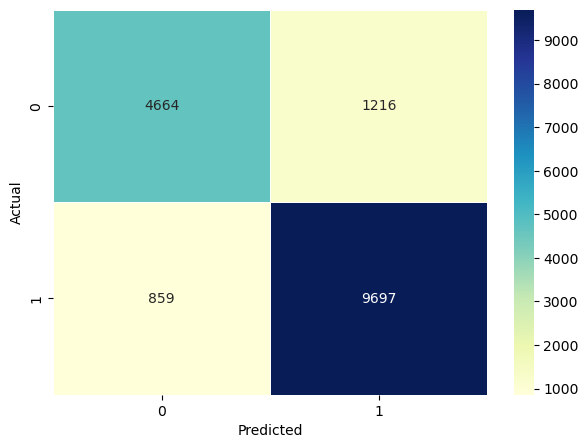

In [144]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic= clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model [2].

In [145]:
crossValScore(clf_logistic, x_train_vectors, y_train)

Mean accuracy: 87.26%, Standard deviation: 0.14%


In [146]:
permImp(clf_logistic, x_test_vectors, y_test, feature_cols)

sentiment_score: 0.021 +/- 0.001
cool: 0.007 +/- 0.001
useful: 0.001 +/- 0.001
funny: 0.001 +/- 0.000


#### 3.2.2.2.b Models applied on subset of Vietnamese restaurants

In [124]:
categories_list = data['categories'].tolist()
cat = pd.DataFrame(categories_list, columns=['categories'])

#number of unique categories
print(len(set(categories_list)))



3861


There are 3861 unique "bunch" of categories in this data. We note that this doesn't mean that there are 3861 different category attributes but means that there are 3861 unique combination of these categories.

In [125]:
value_counts = cat.value_counts().head(10).reset_index(name="count")
value_counts

,categories,count
0,"Restaurants, Breakfast & Brunch",1085
1,"Vietnamese, Restaurants",912
2,"Restaurants, Vietnamese",729
3,"Restaurants, Pizza",653
4,"Pizza, Restaurants",469
5,"Sushi Bars, Japanese, Restaurants",463
6,"Restaurants, Steakhouses",459
7,"Canadian (New), Restaurants",435
8,"Chinese, Restaurants",399
9,"Italian, Restaurants",398


Vietnamise restaurants, under two differently ordered but same categories, are the most frequently mentioned (1641 times) category. We subset them to apply the model.

In [126]:
viet = data[data['categories'].isin(['Vietnamese, Restaurants', 'Restaurants, Vietnamese'])]
viet

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
1673,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",38C7g-G4tlXTzUUYCebgBw,uJTi6gG31LQw1Im5KEu2VQ,3.0,0,1,0,I am really disappointed with the changes to t...,2018-10-03 16:52:33,0,really disappointed change new menu loved chi ...,0.8228
1674,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",GY9hfBvLNV6trl-TdaTmeQ,1mM1SMzqdHxucYUIUFisNw,4.0,1,1,0,My friend Loretta was visiting from out of tow...,2018-08-20 17:35:08,1,friend loretta visiting town celiac disease ea...,0.9936
1675,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",9_-A0_TTHcQI1zY7CC6iuA,B--fSz4A7l69QpBkbC3NUg,4.0,1,0,0,Today our group of four decided to lunch at Se...,2019-11-07 22:56:02,1,today group four decided lunch sen vietnamese ...,0.9866
1676,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",RyBXtSUtyQwIcyAd1XNzFw,4w7QW3CmKyMmUvupdZqTWQ,5.0,1,0,0,This place is a great addition to the Deep Sou...,2018-12-29 18:47:56,1,place great addition deep south really lacked ...,0.7906
4397,itCmUwEvcuN0fNVD_6BYGw,Pho Xuan Restaurant,51.061414,-113.980825,19,"Vietnamese, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",RjEKvpSoGZD1nbVyWO6Xow,JsbgKWAXtkFMOAlePsN64A,4.0,0,0,0,"Always enjoy eating here, they serve a great p...",2016-02-14 07:48:25,1,always enjoy eating here serve great pho tai a...,0.9670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80566,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",fFMRWSR0Hwq15E2gI-Q5og,eYDG3xOctso7tgope7AFcA,3.0,0,0,0,My recent craving for Sushi isn't that hard fo...,2011-11-22 08:02:43,0,recent craving sushi hard believe thing happen...,0.6597
80567,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",27EIdA2TRecAjDPJoxZ-xw,Dd2guCgG8aMmJsxByrzMAQ,2.0,1,0,0,Salad rolls = average at best .\n\nVietnamese ...,2016-01-16 21:49:15,0,salad roll average best vietnamese chicken d...,0.8074
80568,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",-A3Z2BWQ2mRMVSNWksp0tg,7kvWyj2W7DLSfLqt0ypBVQ,3.0,1,3,1,"I know, I know ...\nHealth code violations, ro...",2011-02-21 10:34:30,0,know know health code violation rodent etc et...,-0.2215
80569,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",huBBh9IW83KpzxhMA7QfdA,Px45T2VBCVjN-CyTNeR-LA,3.0,0,0,0,I just had eaten this last night and a drink a...,2019-11-02 18:56:19,0,eaten last night drink supposably odd reason s...,-0.4404


In [127]:
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


MSE: 0.1702127659574468
R2-score: 0.2653907496012756
F1 score: 0.8128403088175539
Accuracy: 0.8297872340425532
Recall: 0.807476076555024


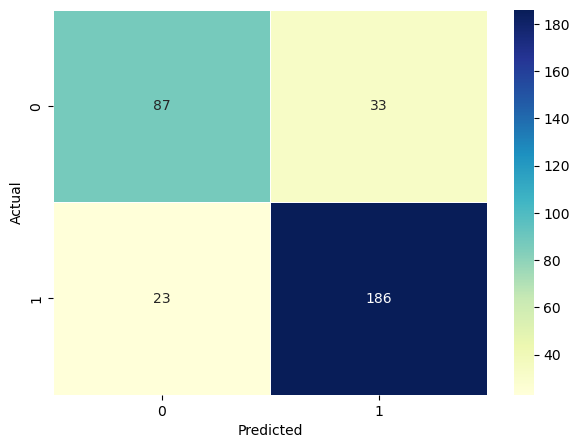

In [128]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [129]:
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors_viet, y_train_viet)
print("Best parameters:", grid_search.best_params_, "Accuracy Score:", grid_search.best_score_)


Best parameters: {'C': 10} Accuracy Score: 0.8559573912286303


In [130]:
gridSearchLogReg(x_train_vectors_viet, y_train_viet)

Best parameters: {'C': 10} Score: 0.8422376170722617


LogisticRegression(C=10, max_iter=10000)

MSE: 0.1702127659574468
R2-score: 0.2653907496012756
F1 score: 0.8128403088175539
Accuracy: 0.8297872340425532
Recall: 0.807476076555024


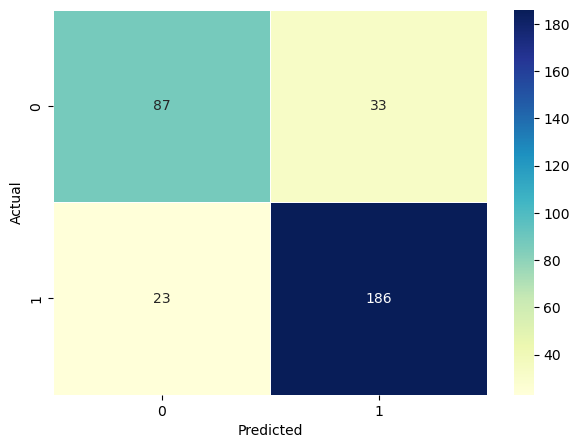

In [131]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [132]:
crossValScore(clf_logistic, x_train_vectors_viet, y_train_viet)


Mean accuracy: 85.60%, Standard deviation: 1.07%


In [133]:
feature_cols = ["cool", "funny", "useful", "latitude","longitude", "sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

MSE: 0.1580547112462006
R2-score: 0.3178628389154703
F1 score: 0.8254997960016319
Accuracy: 0.8419452887537994
Recall: 0.8188197767145136


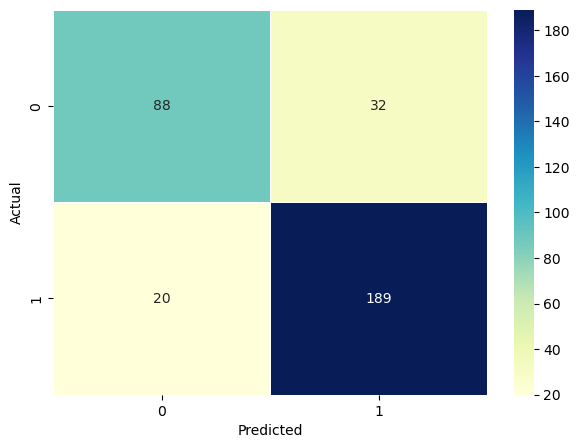

In [134]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [135]:
crossValScore(clf_logistic, x_train_vectors_viet, y_train_viet)

Mean accuracy: 84.83%, Standard deviation: 2.59%


In [136]:
permImp(clf_logistic, x_test_vectors_viet, y_test_viet, feature_cols)

sentiment_score: 0.047 +/- 0.018
latitude: 0.001 +/- 0.001
funny: 0.000 +/- 0.003
useful: 0.000 +/- 0.000
longitude: -0.001 +/- 0.001
cool: -0.003 +/- 0.001


In [137]:
#refreshing the set
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


In [138]:
feature_cols = ["funny", "useful", "latitude","longitude", "sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

MSE: 0.1519756838905775
R2-score: 0.34409888357256757
F1 score: 0.8328931328728159
Accuracy: 0.8480243161094225
Recall: 0.8271531100478469


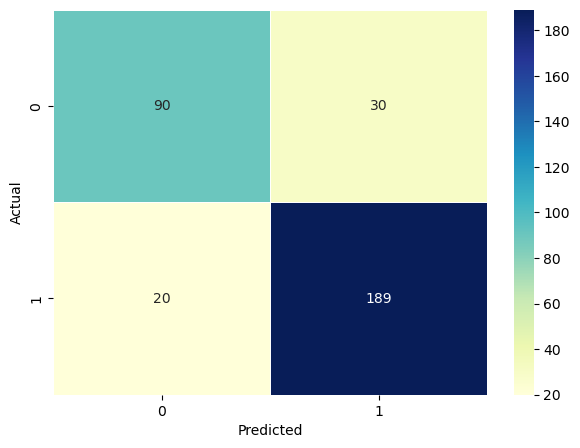

In [139]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [140]:
crossValScore(clf_logistic, x_train_vectors_viet, y_train_viet)

Mean accuracy: 84.99%, Standard deviation: 2.55%


In [141]:
permImp(clf_logistic, x_test_vectors_viet, y_test_viet, feature_cols)

sentiment_score: 0.056 +/- 0.018
latitude: 0.005 +/- 0.003
useful: 0.002 +/- 0.002
funny: 0.002 +/- 0.002
longitude: 0.000 +/- 0.001


Mean accuracy is down by 0.06, we'd like to keep the previous features.

### 3.2.3 Geospatial analysis and visualisation of review data


In [63]:
search_text = 'Chinese'  
chinese = data[data['categories'].str.contains(search_text, case=False)]
chinese = chinese.drop_duplicates(subset='name', keep='first')
chinese

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
27,AsgwKCJqyBqdiHdEBqeq3w,Singapore Sam's,51.042296,-114.073224,37,"Chinese, Restaurants, Buffets","{'Monday': '11:30-12:0', 'Tuesday': '11:30-12:...",yqZsA08aY7Vl0NqBOJrddw,ebMJ9QZj8WhjbR5DrCHyZQ,4.0,3,7,4,There is an unfortunate amount of hate-on goin...,2011-11-30 07:11:58,1,unfortunate amount hateon going ol sam ive dec...,0.9819
286,iDSHlWunyWMS02P8kGyHJQ,80 ATE Indo Chinese Fusion House,51.050889,-114.061939,7,"Restaurants, Asian Fusion, Chinese, Indian, Pa...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22...",XcgVpLCGH19Qv-iznrOpIw,vgymWZvyo2gTQs9FnBjqCA,5.0,1,0,0,Good service and friendly hostess .patiently e...,2019-03-13 21:07:55,1,good service friendly hostess patiently explai...,0.8885
293,ShlkehLaKvDXHLDy4IoUhg,Silver City Restaurant,50.930349,-113.971794,5,"Asian Fusion, Restaurants, Cantonese, Chinese","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",l5KfNC3h6QfV3gEf4OUhcg,TDg10c8ivWqnzzmaCKvgIA,4.0,0,0,0,This is a very authentic Asian restaurant. We ...,2019-06-30 19:53:39,1,authentic asian restaurant mixed fried rice be...,0.9081
882,ikFC6OCWC6dUGocTU8kyBQ,Golden Island Restaurant,51.067135,-114.061189,3,"Restaurants, Himalayan/Nepalese, Chinese","{'Monday': '17:0-0:0', 'Wednesday': '17:0-0:0'...",ezwgq_HW_XW0r2RawVgpZQ,v7SaE-eLhvPbDAkvUO-2gQ,5.0,0,0,0,I used to come here as a kid and I remember th...,2018-06-10 02:37:30,1,used come kid remember restaurant building goo...,0.9245
1226,G-0VVUUoNUKT3GrnjZnsaA,Silver Dragon Restaurant,51.050560,-114.062225,107,"Chinese, Restaurants, Specialty Food, Seafood,...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-22:30',...",7Iz2sRzkbZLilg1CGl4wKQ,fD2BIDg2yV5EMeqzFXkvTQ,4.0,0,0,0,Please note that I only came here for dim sum ...,2018-05-08 15:58:24,1,please note came dim sum never ate menu entran...,0.9516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77972,rO9X1ge-xQZInuy5HYIOIA,Two Penny,51.040981,-114.066177,52,"Restaurants, Chinese, Wine Bars, Asian Fusion,...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-22:0',...",X6xwy0E2b1cRHseVDiT2lw,IVPsn8K58fy_6LbC4t6kLg,5.0,0,1,0,Finally a good Chinese food place in Calgary w...,2017-11-18 21:43:31,1,finally good chinese food place calgary great ...,0.8519
78614,gD5lNqqaXK8HC1SpA04AAw,Spicy Hut,51.051407,-114.051681,35,"Thai, Food, Specialty Food, Ethnic Food, Seafo...","{'Monday': '16:30-22:30', 'Wednesday': '16:30-...",8QdixHcmY1SpEDQUI70IUw,wXi-P691AGOdonMy1TrL7w,4.0,2,0,0,"Everybody has their comfort food - donuts, hoh...",2009-10-20 02:13:04,1,everybody comfort food donut hohos ice cream ...,0.9971
79152,XImlOaB7nJH7kxG_4hGJ1Q,Papa Shunde Chinese Restaurant,51.135477,-114.173506,13,"Restaurants, Chinese","{'Monday': '16:0-22:0', 'Wednesday': '16:0-22:...",wgqRomZ7NUgMs_2hlNh1-g,ZfWx2iL3J_IiDvYLAfDS_w,4.0,1,0,1,This is a very weird place for a restaurant le...,2015-08-20 20:01:24,1,weird place restaurant let alone chinese resta...,-0.1280
79636,qZFyjFr6Chgo0XS520iw6w,Tintin dimsum,50.996124,-114.074317,3,"Restaurants, Cantonese, Bubble Tea, Food, Chinese","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",v5W9mbnyYPe_dm0E6jBdAg,RcsJNYO-Ud7knoFi95uyMA,4.0,0,0,0,Really liked their brisket and rice but it was...,2019-08-30 06:02:00,1,really liked brisket rice i knew place would p...,0.9563


In [64]:
from folium.vector_layers import Circle

gdf = gpd.GeoDataFrame(chinese, geometry=gpd.points_from_xy(chinese.longitude, chinese.latitude))
top_point = gdf.geometry.iloc[0]
map_gdf = folium.Map(location=[top_point.y, top_point.x], zoom_start=11, control_scale = True)

# Getting the minimum and maximum values from the 'count' column
min_value = gdf['stars_y'].min()
max_value = gdf['stars_y'].max()


color_mapper = folium.LinearColormap(colors=['purple', 'yellow'],
                                     index=[min_value, max_value],
                                     vmin=min_value,
                                     vmax=max_value)
color_mapper.caption = 'Stars'
for i, row in gdf.iterrows():
    
    continuous_value = row['stars_y']

    # Getting the color from the color mapper
    icon_color = color_mapper(continuous_value)

    # Creating the marker and add to the map
    folium.Marker([row['latitude'], row['longitude']],
                 icon=folium.Icon(icon = 'star', icon_color=icon_color, markerColor=icon_color),
                 popup=f"Establishment Name: {row['name']}, Stars:  {row['stars_y']}").add_to(map_gdf)



    # Adding the color mapper to the map as a layer control
color_mapper.add_to(map_gdf)

chinatown = [51.050833, -114.065]
radius = 1000

# Create the circle and add it to the map
circle = Circle(location=chinatown, radius=radius, color='red', fill=True, fill_opacity=0.2)
circle.add_to(map_gdf)


map_gdf  

In [71]:


# Define the given coordinate
chinatown = (51.0486, -114.0708)  # Example: Latitude and longitude of the given coordinate


# Convert the given coordinate to radians for haversine calculation
chinatown_rad = tuple(map(radians, chinatown))

# Calculate the distance to the given coordinate for each row in the dataframe
chinese['distance'] = chinese.apply(lambda row: geodesic((row['latitude'], row['longitude']), chinatown).km, axis=1)
# Filter the dataframe to rows within 1 km distance to the given coordinate
filtered_df = chinese[chinese['distance'] <= 1]

# Calculate the average of the value for the filtered rows
average_value = filtered_df['stars_y'].mean()

print("Average rating of Chinese restaurants within 1 km distance to Chinatown: ", average_value)

Average rating of Chinese restaurants within 1 km distance to Chinatown:  4.03030303030303


In [72]:
overall_average = chinese['stars_y'].mean()
print("Average rating of Chinese restaurants in Calgary: ", overall_average)

Average rating of Chinese restaurants in Calgary:  3.7086092715231787


### 3.2.4 Extra task  - Topic Modelling


In [ ]:
def plot_top_words(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# LDA uses raw term counts 

tf = tfidf_vectorizer.fit_transform(data.preprocessed_text)
tf_feature_names = tfidf_vectorizer.get_feature_names_out()


In [ ]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

In [ ]:
# Run LDA
no_topics=10
alpha= 0.5
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                doc_topic_prior=alpha).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

In [ ]:
# Run LDA
no_topics=10
eta= 0.1
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                topic_word_prior=eta).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

In [ ]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='batch', 
                                learning_offset=50.,random_state=0).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

In [ ]:
# Get the topic distribution for each document
doc_topics = lda.transform(tf)

# Create a DataFrame to store the topic assignments for each document
doc_topics_df = pd.DataFrame(columns=['Document', 'Assigned Topic', 'Probability'])

# Assign topics to each document and store the results in the DataFrame
for i, doc in enumerate(doc_topics):
    assigned_topic = doc.argmax()
    probability = doc.max()
    doc_topics_df.loc[i] = [data.preprocessed_text.iloc[i], assigned_topic, probability]

# Print the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f'Top words for Topic {topic_idx + 1}:')
    print([tf_feature_names[i] for i in topic.argsort()[:-11:-1]])
    print('\n')

# Evaluate the topic assignments by printing the top documents for each topic
for topic_idx in range(no_topics):
    print(f'Top documents for Topic {topic_idx + 1}:')
    print(doc_topics_df.loc[doc_topics_df['Assigned Topic'] == topic_idx + 1].sort_values('Probability', ascending=False).head(10))
    print('\n')

In [ ]:
# Create a new DataFrame to combine the document text, the assigned topics, and the probabilities
output_df = pd.concat([data.preprocessed_text, doc_topics_df[['Assigned Topic', 'Probability']]], axis=1)

# Sort the DataFrame by the assigned topics
output_df = output_df.sort_values('Probability')

# Print the output DataFrame
output_df.tail(60)

## Bibliography

* [1] Sklearn.linear_model.logisticregression, Scikit Learn: Machine Learning in Python. Available at: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (Accessed: April 18, 2023). 
* [2] 4.2. permutation feature importance, Scikit Learn: Machine Learning in Python. Available at: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance (Accessed: April 18, 2023). 